https://www.kaggle.com/datasets/kartik2112/fraud-detection/data

In [1]:
import kagglehub
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score,
    roc_curve,
    RocCurveDisplay,
    log_loss,
    recall_score,
    brier_score_loss,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import IsolationForest
import numpy as np
from IPython.display import display, Markdown

import sklearn
sklearn.set_config(transform_output='pandas')

/Users/karinabartolome/Documents/GitHub/workshops/20250905-uba-pipelines/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def plot_distribution(
    data,
    obs_column="y_obs",
    pred_column="pred_prob",
    positive_class=1,
    class_0_color=None,
    class_1_color=None,
):
    if class_0_color is None:
        class_0_color = "blue"
    if class_1_color is None:
        class_1_color = "red"
    # sns.set(font_scale=0.8)
    plt.figure(figsize=(3.5, 1.7))
    sns.kdeplot(
        data=data[data[obs_column] == positive_class],
        x=pred_column,
        color=class_1_color,
        label="Class 1",
    )
    sns.kdeplot(
        data=data[data[obs_column] != positive_class],
        x=pred_column,
        color=class_0_color,
        label="Class 0",
    )
    plt.xlim([0, 1])
    plt.legend()
    plt.show()

# Funciones

In [13]:
## Valores faltantes
def add_random_nans(values, fraction=0.2):
    """
    Generador de valores faltantes
    """
    np.random.seed(42)
    mask = np.random.rand(len(values)) < fraction
    new_values = values.copy()
    new_values[mask] = np.nan
    return new_values
    
class RareCategoryGrouper(BaseEstimator, TransformerMixin):
    """
    Groups infrequent categories into a single label 'infrequent'.
    """

    def __init__(self, variables=None, min_freq=0.05):
        """
        Args:
            variables (list): List of categorical variables to group.
            min_freq (float or int): 
                If float (0 < min_freq < 1), minimum proportion of dataset.
                If int (>=1), minimum absolute count.
        """
        self.variables = variables
        self.min_freq = min_freq
        self.frequent_categories_ = {}

    def fit(self, X, y=None):
        X_ = X.copy()

        if self.variables is None:
            self.variables = X_.select_dtypes(include="object").columns.tolist()

        for var in self.variables:
            freqs = X_[var].value_counts(normalize=isinstance(self.min_freq, float))
            self.frequent_categories_[var] = freqs[freqs >= self.min_freq].index.tolist()

        return self

    def transform(self, X):
        X_ = X.copy()
        for var in self.variables:
            X_[var] = X_[var].where(X_[var].isin(self.frequent_categories_[var]), "infrequent")
        return X_


class MeanEncoder(BaseEstimator, TransformerMixin):
    """
    Mean target encoding for categorical variables.
    Replaces each category with the mean of y for that category.
    """

    def __init__(self, variables=None):
        self.variables = variables
        self.encoding_dict_ = {}
        self.global_mean_ = None

    def fit(self, X, y):
        X_ = X.copy()
        y_ = pd.Series(y)

        if self.variables is None:
            self.variables = X_.select_dtypes(include=["object", "category"]).columns.tolist()

        self.global_mean_ = y_.mean()

        for var in self.variables:
            self.encoding_dict_[var] = y_.groupby(X_[var]).mean().to_dict()

        return self

    def transform(self, X):
        X_ = X.copy()
        for var in self.variables:
            X_[var] = X_[var].map(self.encoding_dict_[var])
            X_[var] = X_[var].fillna(self.global_mean_)  # unseen categories → global mean
        return X_


class OutlierRemover(BaseEstimator, TransformerMixin):
    """
    Removes outliers from numeric columns based on IQR method.
    """
    def __init__(self, numeric_features=None, factor=1.5):
        """
        Args:
            numeric_features (list): list of numeric columns to check for outliers
            factor (float): IQR multiplier, default 1.5
        """
        self.numeric_features = numeric_features
        self.factor = factor

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_ = X.copy()
        
        if self.numeric_features is None:
            self.numeric_features = X_.select_dtypes(include='number').columns.tolist()
        
        # IQR
        Q1 = X_[self.numeric_features].quantile(0.25)
        Q3 = X_[self.numeric_features].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - self.factor * IQR
        upper_bound = Q3 + self.factor * IQR
        
        # Keep only rows where all numeric columns are within bounds
        mask = ~((X_[self.numeric_features] < lower_bound) | (X_[self.numeric_features] > upper_bound)).any(axis=1)
        X_filtered = X_[mask]
        
        # If y is provided, filter it too
        if y is not None:
            y_filtered = y[mask]
            return X_filtered, y_filtered
        
        return X_filtered


class IsolationForestTransformer(BaseEstimator, TransformerMixin):
    """
    Fits an IsolationForest and outputs anomaly scores as a feature.
    """
    def __init__(self, **kwargs):
        self.iforest_kwargs = kwargs

    def fit(self, X, y=None):
        self.iforest_ = IsolationForest(**self.iforest_kwargs)
        self.iforest_.fit(X)
        return self

    def transform(self, X):
        scores = self.iforest_.decision_function(X)
        return pd.DataFrame({"anomaly_score": scores})


# Data

In [5]:
path = kagglehub.dataset_download("kartik2112/fraud-detection")
df_train = pd.read_csv(f"{path}/fraudTrain.csv")
df_test = pd.read_csv(f"{path}/fraudTest.csv")
df = pd.concat([df_train, df_test], axis=0, ignore_index=True).reset_index(drop=True)

cols_selected = [
    "trans_date_trans_time",
    "merchant",
    "category",
    "amt",
    "city_pop",
    "job",
    "dob",
    "zip",
    "lat",
    "long",
    "merch_lat",
    "merch_long",
    "is_fraud",
]
df = df[cols_selected]

In [6]:
# df = df.sample(10000, random_state=42).reset_index(drop=True)

In [7]:
df = df.assign(
    dob = lambda x: add_random_nans(x['dob'], fraction=0.05),
    job = lambda x: add_random_nans(x['job'], fraction=0.1),
    city_pop = lambda x: add_random_nans(x['city_pop'], fraction=0.03),
    merch_lat = lambda x: add_random_nans(x['merch_lat'], fraction=0.02),
    merch_long = lambda x: add_random_nans(x['merch_long'], fraction=0.02),
)

In [8]:
X = df.drop('is_fraud', axis=1)
y = df['is_fraud']
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    shuffle=True,
    stratify=y,
    random_state=42
)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [9]:
print(f"N obs train: {X_train.shape[0]},  % fraude: {y_train.sum()/len(y_train):.2%}")
print(f"N obs test: {X_test.shape[0]},  % fraude: {y_test.sum()/len(y_test):.2%}")

N obs train: 1481915,  % fraude: 0.52%
N obs test: 370479,  % fraude: 0.52%


In [10]:
class TransformacionesIniciales(BaseEstimator, TransformerMixin):
    """
    Transformaciones iniciales del dataset. 
    """

    def __init__(self, age_features=True, timestamp_features=True, distance_features=True):
        """
        Args:
            timestamp_features (bool): Generar variables basadas en la fecha/hora de la trx
            distance_features (bool): Generar variables basadas en la distancia al comercio
        """
        self.age_features = age_features
        self.timestamp_features = distance_features
        self.distance_features = distance_features

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Se genera una copia para no afectar al df original:
        X_ = X.copy()

        # Cast features:
        X_ = (X_
            .assign(
                dob = lambda x: pd.to_datetime(x['dob'], errors='coerce'),
                trans_date_trans_time = lambda x: pd.to_datetime(x["trans_date_trans_time"], errors="coerce"),
            )
        )

        # Features basadas en la edad:
        if self.age_features:
            X_ = X_.assign(
                age = lambda x: round((x['trans_date_trans_time']-x['dob']).dt.days / 365.25,2)
            )

        # Features basadas en fecha y hora de la trx:
        def categorize_part_of_day(hour):
            if 5 <= hour < 12:
                return 'Morning'
            elif 12 <= hour < 17:
                return 'Afternoon'
            elif 17 <= hour < 21:
                return 'Evening'
            elif 21 <= hour or hour < 5:
                return 'Night'

        if self.timestamp_features:
            X_ = X_.assign(
                trans_date__year = lambda x: x["trans_date_trans_time"].dt.year,
                trans_date__month = lambda x: x["trans_date_trans_time"].dt.month,
                trans_date__day = lambda x: x["trans_date_trans_time"].dt.day,
                trans_date__dow = lambda x: x["trans_date_trans_time"].dt.dayofweek,
                trans_date__hour = lambda x: x["trans_date_trans_time"].dt.hour,
                trans_date__partofday = lambda x: x['trans_date__hour'].apply(categorize_part_of_day)
            )

        if self.distance_features:
            # Latitud y longitud en radianes
            lat1 = np.radians(X_['lat'])
            lon1 = np.radians(X_['long'])
            lat2 = np.radians(X_['merch_lat'])
            lon2 = np.radians(X_['merch_long'])
            
            # Fórmula Haversine para calcular la distancia:
            dlat = lat2 - lat1
            dlon = lon2 - lon1
            a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
            c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
            R = 6371  # Radio de la tierra (en kilometros)
            X_['distance_to_merch'] = round(R * c, 3) # Distancia (en kilometros)

        X_ = X_.drop(['trans_date_trans_time','dob'], axis=1) 
        return X_

In [11]:
preproc_categoricas = Pipeline(steps=[
    ('rare_labels', RareCategoryGrouper(min_freq=0.01)),
    ('imputar_nulos', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('mean_encoder', MeanEncoder())
])

preproc_numericas = Pipeline(steps=[
    ('imputar_nulos', SimpleImputer(strategy='median'))
])

feature_eng = ColumnTransformer([
    ('cat', preproc_categoricas, make_column_selector(dtype_exclude=['float','int'])),
    ('num', preproc_numericas, make_column_selector(dtype_include=['float','int']))
], verbose_feature_names_out=False, remainder='drop', verbose=True)

from sklearn.pipeline import FeatureUnion
preproc = Pipeline([
    ('init', TransformacionesIniciales()),
    ('feature_eng', feature_eng),
    ('features', FeatureUnion([
            ('anomaly', IsolationForestTransformer()),
            ('outliers', OutlierRemover())
        ])
    )
], verbose=True)

preproc

,steps,"[('init', ...), ('feature_eng', ...), ...]"
,transform_input,None
,memory,None
,verbose,True
,age_features,True
,timestamp_features,True
,distance_features,True
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None


In [12]:
preproc.fit(X_train, y_train)
X_transformed = preproc.transform(X_train)
X_transformed.head(2)

[Pipeline] .............. (step 1 of 3) Processing init, total=   2.2s
[ColumnTransformer] ........... (1 of 2) Processing cat, total=   2.8s
[ColumnTransformer] ........... (2 of 2) Processing num, total=   3.3s
[Pipeline] ....... (step 2 of 3) Processing feature_eng, total=   6.2s


TypeError: IsolationForestTransformer.fit() takes 2 positional arguments but 3 were given

In [ ]:
from catboost import CatBoostClassifier

In [ ]:
# cat_features = preproc.fit_transform(X_train.sample(1000, random_state=42)).select_dtypes(['category','object']).columns.tolist()

clf = CatBoostClassifier(
    iterations=500,
    # depth=6,
    #learning_rate=0.1,
    loss_function="Logloss",
    eval_metric="Recall",
    class_weights=[1, 20],
    random_seed=42,
    verbose=100,
    # cat_features = cat_features
    
)

pipe = Pipeline([
    ('preproc', preproc),
    ('model', clf)   
])

pipe

,steps,"[('preproc', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('init', ...), ('feature_eng', ...), ...]"
,transform_input,None
,memory,None
,verbose,True
,age_features,True
,timestamp_features,True
,distance_features,True


In [ ]:
pipe.fit(X_train, y_train)

[Pipeline] .............. (step 1 of 3) Processing init, total=   0.2s
[ColumnTransformer] ........... (1 of 2) Processing cat, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing num, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing feature_eng, total=   0.0s
scores ok
[Pipeline] .......... (step 3 of 3) Processing features, total=   0.2s
Learning rate set to 0.047271
0:	learn: 0.6046512	total: 7.3ms	remaining: 3.64s
100:	learn: 0.6744186	total: 343ms	remaining: 1.35s
200:	learn: 0.7209302	total: 774ms	remaining: 1.15s
300:	learn: 0.7441860	total: 1.12s	remaining: 741ms
400:	learn: 0.7906977	total: 1.45s	remaining: 357ms
499:	learn: 0.8139535	total: 1.76s	remaining: 0us


,steps,"[('preproc', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('init', ...), ('feature_eng', ...), ...]"
,transform_input,None
,memory,None
,verbose,True
,age_features,True
,timestamp_features,True
,distance_features,True


In [ ]:
df_preds_test = pd.DataFrame({
    'y_true': y_test.reset_index(drop=True),
    'y_pred_class': pipe.predict(X_test),
    'y_pred_prob': round(pd.Series(pipe.predict_proba(X_test)[:,1]),4)
})

scores ok
scores ok


/Users/karinabartolome/Documents/GitHub/workshops/20250905-uba-pipelines/.venv/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/karinabartolome/Documents/GitHub/workshops/20250905-uba-pipelines/.venv/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


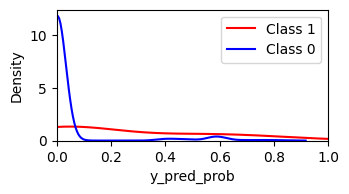

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plot_distribution(data=df_preds_test,obs_column='y_true',pred_column='y_pred_prob')

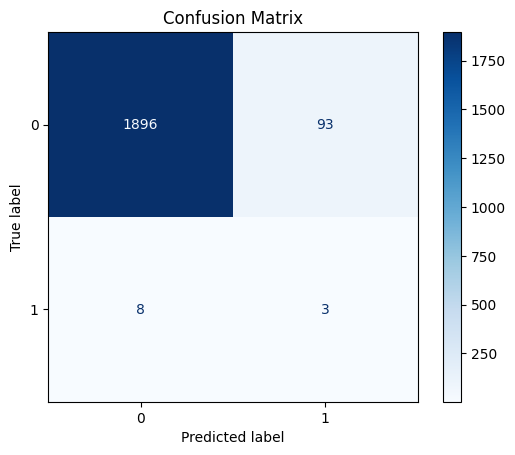

In [ ]:
cm = confusion_matrix(df_preds_test['y_true'], df_preds_test['y_pred_class'])

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()

scores ok


/Users/karinabartolome/Documents/GitHub/workshops/20250905-uba-pipelines/.venv/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/var/folders/yj/d4vhy9bd1pd_6x4jtc6dymhw0000gn/T/ipykernel_63276/312735048.py:19: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_transformed)


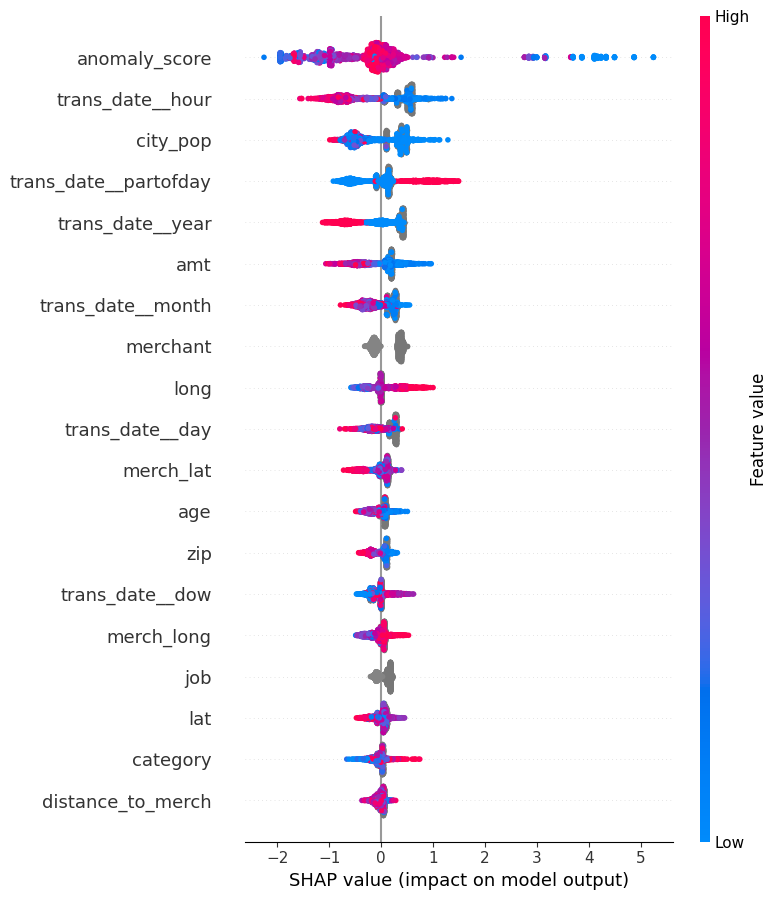

In [ ]:
from catboost import CatBoostClassifier, Pool
import shap
import matplotlib.pyplot as plt
X_test_transformed = pipe[:-1].transform(X_test)

test_pool = Pool(
    X_test_transformed,
    label=y_test,
    # cat_features=cat_features
)

shap_values = pipe[-1].get_feature_importance(
    test_pool, 
    type="ShapValues"
)

shap_values = shap_values[:, :-1]

shap.summary_plot(shap_values, X_test_transformed)

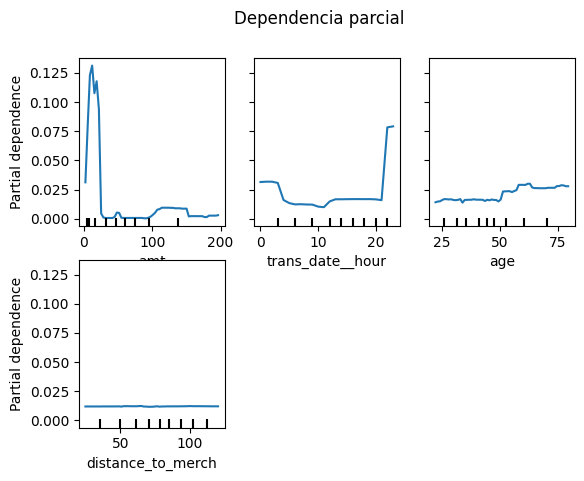

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

features_to_plot = ["amt", "trans_date__hour", "age", "distance_to_merch"] 

PartialDependenceDisplay.from_estimator(
    pipe[-1],
    X_test_transformed,
    features=features_to_plot,
    kind="average",  # 'average' = standard PDP, 'individual' = ICE plots
    grid_resolution=60,
    target=1 # Clasificación binaria
)

plt.suptitle("Dependencia parcial")
plt.show()


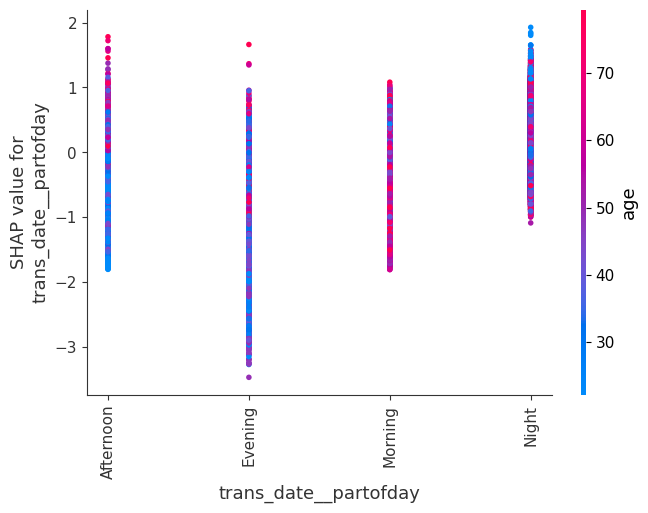

In [ ]:
# choose the feature you want to plot
feature_name = "trans_date__partofday"           # x-axis feature
interaction_feature = "age"   # optional, color by this feature

# SHAP dependence plot
shap.dependence_plot(
    feature_name,
    shap_values,
    X_test_transformed,
    interaction_index=interaction_feature,
    show=True
)
